## Comaprison
The aim of this notebook is to compare two approaches to image generation. These are:
 - Image generation using only the diffusion model,
 - image generation by combining WGAN model with diffusion model.

The diffusion model takes a tensor of shape `1x16x16`, time step and class vector. The input tensor is random noise sampled from normal distribution. Then by iteration of 150 steps, the noise is filtered out from the input and in the end a real image is obtained.  

The combination of WGAN and diffusion models works as follows. First WGAN is supplide with a vector of shape 32. The vector is generated by sampling a random distribution. WGAN generates the noise expected by the diffusion model at the 80th time step. The noise generated by WGAN is passed to the diffusion model along with the timestep and the desired class. Then by iteration of 80 steps the noise is filtered out from the input and in the end a real image is obtained.  

At present, WGAN does not support conditional noise generation (passing the desired class to the model input) and this functionality will be added later.  

The dataset on which both models were trained is fashion-mnist.  

In [1]:
import mlflow
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [2]:
import image_gen.models.utils.image_diffusers as idiff
img_diffuser = idiff.imageDiffuser(150, **{"t_start": 1e-4, "t_end": 2e-2,})

In [37]:
# Loading WGAN and diffusion model
sd_logged_model = 'runs:/81b61218eb664af6a9ac3e6c8d1ab7ff/1729498024.pt'
gan_logged_model = 'runs:/c45eae470cd24127936ba39814bab930/1729537152.pt'

sd = mlflow.pytorch.load_model(sd_logged_model, **{'map_location': torch.device('cpu')}) 
gan = mlflow.pytorch.load_model(gan_logged_model, **{'map_location': torch.device('cpu')}) 

2024/10/21 21:45:00 WARNING mlflow.pytorch: Stored model version '2.3.1' does not match installed PyTorch version '2.4.1'
2024/10/21 21:45:07 WARNING mlflow.pytorch: Stored model version '2.3.1' does not match installed PyTorch version '2.4.1'


In [67]:
# Measuring the performance of the combination of WGAN and diffusion model
%%timeit -n 10
batch_size = 1
t_gan = 80
cat = torch.zeros(batch_size,10)
cat[:,5] = 1
t = torch.ones(batch_size,1).long()
gan_sd_img  = gan(torch.randn(batch_size,32))


for _t in  range(t_gan, -1, -1):
    gan_sd_img  = img_diffuser.reverse(gan_sd_img , sd(gan_sd_img , _t*t, cat), _t*t)


499 ms ± 113 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


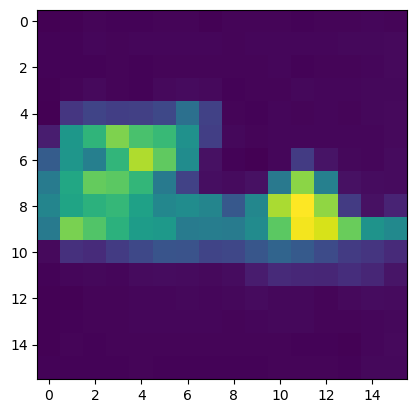

In [66]:
# Visulization of the image obtained from the combination of WGAN and diffusion model
# a sandal
plt.imshow(gan_sd_img [0,0])

In [70]:
# Measuring the performance of the diffusion model
%%timeit -n 10
batch_size = 1
t_sd = 150
cat = torch.zeros(batch_size,10)
cat[:,5] = 1
t = torch.ones(batch_size,1).long()
sd_img = torch.randn(1,1,16,16)


for _t in  range(t_sd-1, -1, -1):
    sd_img  = img_diffuser.reverse(sd_img , sd(sd_img , _t*t, cat), _t*t)


1.12 s ± 168 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


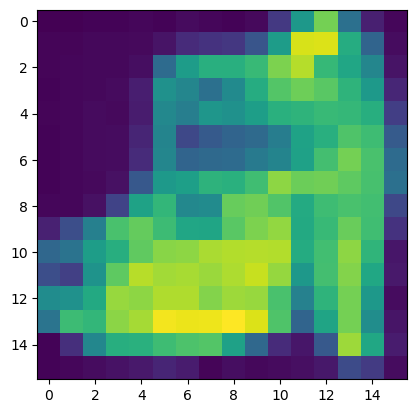

In [69]:
# Visulization of the image obtained from the diffusion model
# a sandal
plt.imshow(sd_img [0,0])